In [27]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
import umap
import umap.plot
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
size = (150, 150)
import plotly.express as px
import molplotly # requires dash version 2.0 (latest = 2.1); use pip list and pip install dash==2.0
import mols2grid
from tdc.single_pred import ADME
import useful_rdkit_utils as uru
from tqdm import tqdm
from IPython.display import SVG

## Setup

Make reos object

In [3]:
reos = uru.REOS()
rule_path = reos.get_rule_file_location()
print('Rules file:',rule_path)
print('Available sets of rules:',reos.get_available_rule_sets())

Rules file: /Users/cian/.data/useful_rdkit_utils/data/alert_collection.csv
Available sets of rules: ['Glaxo' 'Dundee' 'BMS' 'PAINS' 'SureChEMBL' 'MLSMR' 'Inpharmatica' 'LINT']


## Information on the rules (see introduction below)

In [4]:
df_rules = pd.read_csv("/Users/cian/.data/useful_rdkit_utils/data/alert_collection.csv")
df_rules

#df_rules['rule_set_name'].value_counts()    # Numbers of rules in each set

,rule_id,rule_set,description,smarts,rule_set_name,priority,max
0,1,1,R1 Reactive alkyl halides,"[Br,Cl,I][CX4;CH,CH2]",Glaxo,8,0
1,2,1,R2 Acid halides,"[S,C](=[O,S])[F,Br,Cl,I]",Glaxo,8,0
2,3,1,R3 Carbazides,O=CN=[N+]=[N-],Glaxo,8,0
3,4,1,R4 Sulphate esters,"COS(=O)O[C,c]",Glaxo,8,0
4,5,1,R5 Sulphonates,"COS(=O)(=O)[C,c]",Glaxo,8,0
...,...,...,...,...,...,...,...
1246,1247,8,too many cyano Groups (>1),C#N.C#N,LINT,2,0
1247,1248,8,too many COOH groups (>1),[CX3](=O)[OH1].[CX3](=O)[OH1],LINT,2,0
1248,1249,8,amino acid,[NH2][CX4]C(=O)O,LINT,2,0
1249,1250,8,chlorates,Cl~O,LINT,2,0


Evaluate a specific set(s) of rules

In [7]:
specific_rules = ['BMS']
#specific_rules = ['Glaxo','BMS','PAINS']

filtered_df = df_rules[df_rules['rule_set_name'].isin(specific_rules)]
filtered_df

,rule_id,rule_set,description,smarts,rule_set_name,priority,max
160,161,3,2halo_pyrazine_3EWG,"[#7;R1]1[#6]([F,Cl,Br,I])[#6]([$(S(=O)(=O)),$(...",BMS,7,0
161,162,3,2halo_pyrazine_5EWG,"[#7;R1]1[#6]([F,Cl,Br,I])[#6;!$(c-N)][#7][#6](...",BMS,7,0
162,163,3,2halo_pyridazine_3EWG,"[#7;R1]1[#6]([F,Cl,Br,I])[#6]([$(S(=O)(=O)),$(...",BMS,7,0
163,164,3,2halo_pyridazine_5EWG,"[#7;R1]1[#6]([F,Cl,Br,I])[#6][#6][#6]([$(S(=O)...",BMS,7,0
164,165,3,2halo_pyridine_3EWG,"[#7;R1]1[#6;!$(c=O)]([F,Cl,Br,I])[#6]([$(S(=O)...",BMS,7,0
...,...,...,...,...,...,...,...
335,336,3,trinitro_aromatic,"[$(a1aaa([$(N(=O)(=O)),$([N+](=O)[O-])])a([$(N...",BMS,7,0
336,337,3,trinitromethane_derivative,"C([$([N+](=O)[O-]),$(N(=O)=O)])([$([N+](=O)[O-...",BMS,7,0
337,338,3,tris_activated_aryl_ester,"[$(O=[C,S]Oc1a([$(S(=O)(=O)),F,$(C(F)(F)(F)),$...",BMS,7,0
338,339,3,trisub_bis_act_olefin,"[CH;!R;!$(C-N)]=C([$(S(=O)(=O)),$(C(F)(F)(F)),...",BMS,7,0


In [ ]:
filtered_df.to_csv('structural_alerts.csv', index = True)

Print the substructures (doesnt work for many of the smarts)

In [ ]:
grid = mols2grid.MolGrid(df_selected_rules, smiles_col="smarts", size=(175, 200), name="something")
grid.display(subset=["rule_id","description","img"], n_cols=5)

## Analyze one compound

Analysis uses 8 sets of rules, Ixabepilone shown as example (used in treatment of breast cancer)

'ok' indicates no structural alert was found

In [135]:
check_smiles = "CC1CCCC2(C(O2)CC(NC(=O)CC(C(C(=O)C(C1O)C)(C)C)O)C(=CC3=CSC(=N3)C)C)C"   # choose your smiles


columns = ['Rule set','No. of rules','Alert']
df = pd.DataFrame(columns=columns, dtype=object)

rule_sets = ['Glaxo','Dundee','BMS','PAINS','SureChEMBL','MLSMR','Inpharmatica','LINT']
for i in rule_sets:
    reos.set_active_rule_sets(i)
    rule_set = reos.get_active_rule_sets()
    number = reos.active_rule_df.shape[0]
    x = list(reos.process_smiles(check_smiles))
    df = df.append({'Rule set':rule_set[0], 'No. of rules':number, 'Alert':x[1]} , ignore_index=True)
df

,Rule set,No. of rules,Alert
0,Glaxo,55,"I6 Epoxides, Thioepoxides, Aziridines"
1,Dundee,105,Three-membered heterocycle
2,BMS,180,ok
3,PAINS,481,ok
4,SureChEMBL,166,"epoxides,_thioepoxides,_aziridines"
5,MLSMR,116,Ketone
6,Inpharmatica,91,Filter40_epoxide_aziridine
7,LINT,57,epoxides


Choose the row to visualize (0-7). A lot of alerts give rdkit errors and cannot be visualized

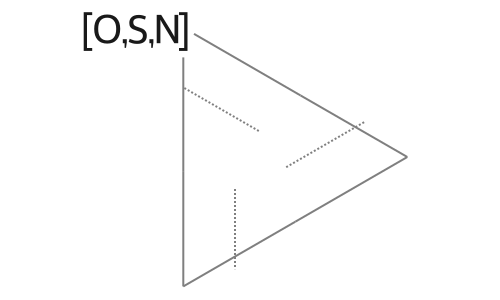

In [143]:
row = 0 

x = df.loc[row]
rule_set = x[0]
rule_name = x[2]
reos.set_active_rule_sets([rule_set])
alert_smiles = reos.active_rule_df.query("rule_set_name == @rule_set and description == @rule_name").pat.values
d2d = rdMolDraw2D.MolDraw2DSVG(500,300)
rdMolDraw2D.PrepareAndDrawMolecule(d2d, alert_smiles[0])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

Highlight the structural alert on the compound of interest

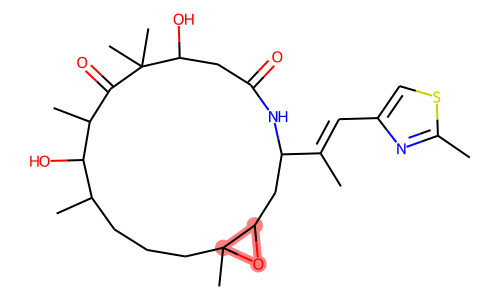

In [144]:
mol = Chem.MolFromSmiles(check_smiles)
hit_ats = list(mol.GetSubstructMatch(alert_smiles[0]))
hit_bonds = []
for bond in alert_smiles[0].GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
d2d = rdMolDraw2D.MolDraw2DSVG(500,300)
rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol, highlightAtoms=hit_ats, highlightBonds=hit_bonds)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

## Analyze multiple compounds

Set the active rules

In [145]:
reos.set_active_rule_sets(['Glaxo','BMS'])
#reos.set_active_rule_sets(['Glaxo','Dundee','BMS','PAINS','SureChEMBL','MLSMR','Inpharmatica','LINT'])

print('Currently active rule set(s):',reos.get_active_rule_sets())
print('Number of currently active rules:',reos.active_rule_df.shape[0])

Currently active rule set(s): ['Glaxo' 'BMS']
Number of currently active rules: 235


Read in compound info

In [148]:
df = pd.read_csv("drugbank_data_v1.csv")     
df = df.drop(columns=['Unnamed: 0','dimension 1','dimension 2'])             # drop some unnecessary columns
df.index = df.index.astype(int)

#df2 = df.copy()
df2 = df.head(1000)
df2

,CID,names,smiles,rdmol_optimized
0,445722,DB03657|N-(methoxycarbonyl)-beta-D-glucopyrano...,COC(=O)N[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)...,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,448006,"(+)-2-(4-biphenyl)propionic acid|2-(1,1'-BIPHE...",C[C@@H](C1=CC=C(C=C1)C2=CC=CC=C2)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,444719,METHIONINE PHOSPHONATE|DB02151,CSCC[C@H](N)P(=O)(O)O,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,4064,meprobamate|Meprobamic acid|DB00371,CCCC(C)(COC(=O)N)COC(=O)N,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,2131,ambenonium|Ambenonum|Ambenonium Base|DB01122,CC[N+](CC)(CCNC(=O)C(=O)NCC[N+](CC)(CC)CC1=CC=...,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...
995,5323,sulfadimethoxine|Sulphadimethoxine|Sulfadimeth...,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC,"<img data-content=""rdkit/molecule"" src=""data:i..."
996,12035,acetylcysteine|N-Acetyl-L-cysteine|N-Acetylcys...,CC(=O)N[C@@H](CS)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i..."
997,104850,Rimonabant|DB06155,CC1=C(N(N=C1C(=O)NN2CCCCC2)C3=C(C=C(C=C3)Cl)Cl...,"<img data-content=""rdkit/molecule"" src=""data:i..."
998,6918173,Icatibant|DB06196,C1CC[C@H]2[C@@H](C1)C[C@H](N2C(=O)[C@H]3CC4=CC...,"<img data-content=""rdkit/molecule"" src=""data:i..."


Apply the rules to the compounds

In [149]:
x = df2.smiles.apply(reos.process_smiles).to_list()
y, z = zip(*x)
df2['rule_set_name'] = y
df2['problem substructure'] = z
df2

,CID,names,smiles,rdmol_optimized,rule_set_name,problem substructure
0,445722,DB03657|N-(methoxycarbonyl)-beta-D-glucopyrano...,COC(=O)N[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)...,"<img data-content=""rdkit/molecule"" src=""data:i...",ok,ok
1,448006,"(+)-2-(4-biphenyl)propionic acid|2-(1,1'-BIPHE...",C[C@@H](C1=CC=C(C=C1)C2=CC=CC=C2)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",ok,ok
2,444719,METHIONINE PHOSPHONATE|DB02151,CSCC[C@H](N)P(=O)(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",ok,ok
3,4064,meprobamate|Meprobamic acid|DB00371,CCCC(C)(COC(=O)N)COC(=O)N,"<img data-content=""rdkit/molecule"" src=""data:i...",ok,ok
4,2131,ambenonium|Ambenonum|Ambenonium Base|DB01122,CC[N+](CC)(CCNC(=O)C(=O)NCC[N+](CC)(CC)CC1=CC=...,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,I11 Benzylic quaternary Nitrogen
...,...,...,...,...,...,...
995,5323,sulfadimethoxine|Sulphadimethoxine|Sulfadimeth...,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC,"<img data-content=""rdkit/molecule"" src=""data:i...",ok,ok
996,12035,acetylcysteine|N-Acetyl-L-cysteine|N-Acetylcys...,CC(=O)N[C@@H](CS)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,I5 Thiols
997,104850,Rimonabant|DB06155,CC1=C(N(N=C1C(=O)NN2CCCCC2)C3=C(C=C(C=C3)Cl)Cl...,"<img data-content=""rdkit/molecule"" src=""data:i...",ok,ok
998,6918173,Icatibant|DB06196,C1CC[C@H]2[C@@H](C1)C[C@H](N2C(=O)[C@H]3CC4=CC...,"<img data-content=""rdkit/molecule"" src=""data:i...",ok,ok


Check the number of problematic substructures. 

If more than one set of rules was used than go to section 6 (only one rule break will be counted per molecule).

In [150]:
df2['rule_set_name'].value_counts()

ok       695
BMS      154
Glaxo    151
Name: rule_set_name, dtype: int64

List the substructure alerts found

In [151]:
df2['problem substructure'].value_counts()

ok                                              695
I15 Di and Triphosphates                         31
I1 Aliphatic methylene chains 7 or more long     27
contains_metal                                   25
aldehyde                                         17
                                               ... 
R21 Nitroso                                       1
trifluoromethyl_ketone                            1
hydrazine                                         1
tertiary_halide_sulfate                           1
R14 phosphoramides                                1
Name: problem substructure, Length: 61, dtype: int64

## Closer inspection and visualization of compounds with structural alerts

Filter compounds without structural alerts

In [152]:
df3 = df2.copy()
df3 = df3[df3['rule_set_name'] != 'ok']
df3

,CID,names,smiles,rdmol_optimized,rule_set_name,problem substructure
4,2131,ambenonium|Ambenonum|Ambenonium Base|DB01122,CC[N+](CC)(CCNC(=O)C(=O)NCC[N+](CC)(CC)CC1=CC=...,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,I11 Benzylic quaternary Nitrogen
5,135398619,guanosine-5'-diphosphate|DB04315,C1=NC2=C(N1[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O...,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,I15 Di and Triphosphates
7,145729,DEOXYURIDINE-5'-DIPHOSPHATE|DB03413,C1[C@@H]([C@H](O[C@H]1N2C=CC(=O)NC2=O)COP(=O)(...,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,I15 Di and Triphosphates
13,5289143,LYSOPHOSPHATIDYLGLYCEROL|DB03438,CCCCCCCCCCCCCCCC(=O)OC[C@@H](COP(=O)([O-])OC[C...,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,I1 Aliphatic methylene chains 7 or more long
14,447236,8-BROMOADENOSINE-5'-DIPHOSPHATE|DB04554,C1=NC(=C2C(=N1)N(C(=N2)Br)[C@H]3[C@@H]([C@@H](...,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,I15 Di and Triphosphates
...,...,...,...,...,...,...
981,21700,BECLOMETHASONE DIPROPIONATE|Beclometasone dipr...,CCC(=O)OCC(=O)[C@]1([C@H](C[C@@H]2[C@@]1(C[C@@...,"<img data-content=""rdkit/molecule"" src=""data:i...",BMS,tertiary_halide_sulfate
983,4121,methyclothiazide|DB00232,CN1C(NC2=CC(=C(C=C2S1(=O)=O)S(=O)(=O)N)Cl)CCl,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,R1 Reactive alkyl halides
986,6445540,Ixabepilone|Azaepothilone B|Aza-epothilone B|D...,C[C@H]1CCC[C@@]2([C@@H](O2)C[C@H](NC(=O)C[C@@H...,"<img data-content=""rdkit/molecule"" src=""data:i...",Glaxo,"I6 Epoxides, Thioepoxides, Aziridines"
994,56927674,Myostibin|Stibanate|Stibanose|Stibatin|Stibino...,C([C@H]([C@@H]1[C@H]2[C@@H](O[Sb](O2)(O1)O[Sb]...,"<img data-content=""rdkit/molecule"" src=""data:i...",BMS,contains_metal


In [153]:
grid = mols2grid.MolGrid(df3, smiles_col="smiles", size=(175, 200), name="something")
grid.display(subset=["CID",'rule_set_name',"problem substructure","img"], n_cols=5)

Pick a specific compound to visualize the structural alert (CIDs are displayed in the mols2grid boxes)

Broken rule = I11 Benzylic quaternary Nitrogen


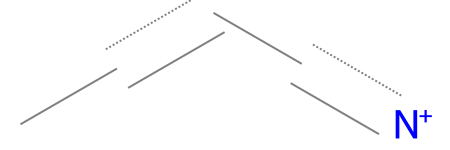

In [155]:
CID = 2131

df4 = df3.loc[df3['CID'] == CID]
smiles = df4.iloc[0]['smiles']
mol = Chem.MolFromSmiles(smiles)
rule_set = df4.iloc[0]['rule_set_name']
rule_name = df4.iloc[0]['problem substructure']
alert_smiles = reos.active_rule_df.query("rule_set_name == @rule_set and description == @rule_name").pat.values

print('Broken rule =',rule_name)
alert_smiles[0]

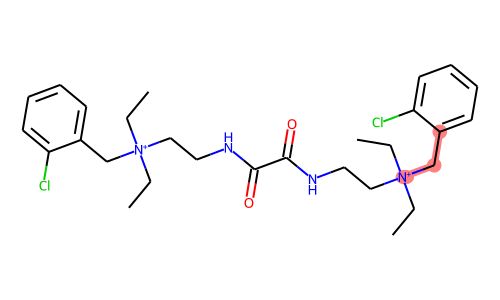

In [156]:
hit_ats = list(mol.GetSubstructMatch(alert_smiles[0]))
hit_bonds = []
for bond in alert_smiles[0].GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
d2d = rdMolDraw2D.MolDraw2DSVG(500,300)
rdMolDraw2D.PrepareAndDrawMolecule(d2d, mol, highlightAtoms=hit_ats, highlightBonds=hit_bonds)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

## Individually check the number of substructure hits with each set of rules

Has the potential to be slow. It took 1 min 49 sec to check the 10621 structures in the drugbank set using all 8 sets of rules.

In [158]:
df = pd.read_csv("drugbank_data_v1.csv")     
df = df.drop(columns=['Unnamed: 0','dimension 1','dimension 2'])             # drop some unnecessary columns
df.index = df.index.astype(int)

#df2 = df.copy()
df2 = df.head(1000)
df2

,CID,names,smiles,rdmol_optimized
0,445722,DB03657|N-(methoxycarbonyl)-beta-D-glucopyrano...,COC(=O)N[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)...,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,448006,"(+)-2-(4-biphenyl)propionic acid|2-(1,1'-BIPHE...",C[C@@H](C1=CC=C(C=C1)C2=CC=CC=C2)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,444719,METHIONINE PHOSPHONATE|DB02151,CSCC[C@H](N)P(=O)(O)O,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,4064,meprobamate|Meprobamic acid|DB00371,CCCC(C)(COC(=O)N)COC(=O)N,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,2131,ambenonium|Ambenonum|Ambenonium Base|DB01122,CC[N+](CC)(CCNC(=O)C(=O)NCC[N+](CC)(CC)CC1=CC=...,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...
995,5323,sulfadimethoxine|Sulphadimethoxine|Sulfadimeth...,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC,"<img data-content=""rdkit/molecule"" src=""data:i..."
996,12035,acetylcysteine|N-Acetyl-L-cysteine|N-Acetylcys...,CC(=O)N[C@@H](CS)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i..."
997,104850,Rimonabant|DB06155,CC1=C(N(N=C1C(=O)NN2CCCCC2)C3=C(C=C(C=C3)Cl)Cl...,"<img data-content=""rdkit/molecule"" src=""data:i..."
998,6918173,Icatibant|DB06196,C1CC[C@H]2[C@@H](C1)C[C@H](N2C(=O)[C@H]3CC4=CC...,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [159]:
rule_sets_list = ['Glaxo','Dundee','BMS','PAINS','SureChEMBL','MLSMR','Inpharmatica','LINT']
#rule_sets_list = ['Glaxo','Dundee','BMS']

counts=[]
for i in tqdm(rule_sets_list):
    try:
        reos.set_active_rule_sets(i)
        #print('Currently active set of rules:',reos.get_active_rule_sets())
        #print('Number of rules:',reos.active_rule_df.shape[0])
        x = df2.smiles.apply(reos.process_smiles).to_list()
        y, z = zip(*x)
        df2[str(i)] = y
        z = list(filter(('ok').__ne__, y))
        a = len(z)
        counts.append(a)
        #df_rules['problem substructure ',str(i)] = z
    except:
        pass
    
print(len(df2),'compounds were examined:\n')
for i in range(0,len(rule_sets_list)):
    print(rule_sets_list[i],'found',counts[i],'problematic structures\n')

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]

1000 compounds were examined:

Glaxo found 151 problematic structures

Dundee found 560 problematic structures

BMS found 273 problematic structures

PAINS found 28 problematic structures

SureChEMBL found 287 problematic structures

MLSMR found 663 problematic structures

Inpharmatica found 253 problematic structures

LINT found 569 problematic structures



## Adding the PAINS data to an existing file

In [ ]:
df = pd.read_csv("drugbank_data_v2.csv")     
df = df.drop(columns=['Unnamed: 0'])             # drop an unnecessary columns
df.index = df.index.astype(int)
df2 = df.copy()
df2

Run individually: Change the rules and rerun for each set you want to incorporate

In [ ]:
rules_set = 'PAINS' # run the sets individually ('Glaxo','Dundee','BMS','PAINS','SureChEMBL','MLSMR','Inpharmatica','LINT')

reos.set_active_rule_sets([rules_set]) 
print('Currently active rule set(s):',reos.get_active_rule_sets())
print('Number of currently active rules:',reos.active_rule_df.shape[0])

In [ ]:
x = df2.smiles.apply(reos.process_smiles).to_list()
y, z = zip(*x)
#df2['rules'] = y   # unnecessary information
df2[rules_set] = z
df2[rules_set+' pass'] = df2[rules_set] == 'ok'    # True/False list for UMAP coloring
df2

In [ ]:
df2.to_csv('drugbank_data_v3.csv', index = True)

## Introduction, overview of the sets of rules, and references

alse positives in biochemical or cellular assays can occur due to a variety of biological effects, such as colloidal aggregation. Other problematic compounds tend to react nonspecifically with numerous biological targets rather than specifically affecting one desired target. Certain substructures/functional groups are more prone to produce false positive assay results. Hence, sets of "rules", or problematic substructures, have been devised to filter compounds prior to medicinal chemistry screening. The most common set of rules was compiled based on a study into the identification of pan-assay interference compounds (PAINS). The code below contains 8 different sets of rules derived from the ChEMBL database by Pat Walters. Information on the rules came from a pdf available online I checked 10621 compounds from DrugBank (DB) for rule violations with each set, the number of problematic compounds is given below. The validity of the rules is the subject of much debate and therefore they should not be used to filter compounds blindly.

**'Glaxo' = 55 rules, 1303/10621 DB alerts**

J. Chem. Inf. Comput. Sci. 1999, 39, 897-902 - known to be updated internally within GSK (but not released publically)

**'Dundee' = 105 rules, 5499/1062 DB alerts (aggressive)**

ChemMedChem 2008, 3, 435-444

**'BMS' = 180 rules, 2397/10621 DB alerts**

J. Chem. Inf. Model. 2006, 46, 1060-1068 - based on BMS chemist's chemical intuition and experience. Two types of alerts; exclusion filters are those intended for compound removal from screening decks while informational filters are useful for compound annotation. Not obvious which is which.

**'PAINS' = 481 rules, 386/10621 DB alerts**

J. Med. Chem. 2010, 53, 2719-2740.

**'SureChEMBL' = 166 rules, 2951/10621 DB alerts (not peer-reviewed)**

https://www.surechembl.org/knowledgebase/169485-non-medchem-friendly-smarts

**'MLSMR' = 116 rules, 6330/10621 DB alerts (not peer-reviewed)**

NIH Molecular Libraries Small Molecule Repository ‘Excluded Functionality Filters’

**'Inpharmatica' = 91 rules, 2901/10621 DB alerts (not peer-reviewed)**

Filters used at Inpharmatica to identify ‘unwanted fragments’, this was a personal communication

**'LINT' = 57 rules, 5229/10621 DB alerts (aggressive)**

Pfizer's set; Med. Chem. 2005, 1, 649-655

∼50% of approved drugs have one or more alerts from these sets. Thus, the rules should be used for structural alerts rather than direct filters. Evaluate small sets of compounds using the 8 set of rules. Larger sets where evaluation of individual alerts will be harder and require careful data analysis. Based on my analysis I would favor Glaxo, BMS, and PAINS because they are less aggressive, are published in peer reviewed journals, and come from experienced industrial scientists. However, check the amount of compound alerts for your dataset with each set of rules.

----

*References*

Code from: https://github.com/PatWalters/useful_rdkit_utils/blob/master/notebooks/demo_REOS.ipynb

More info on the (ChEMBL derived) structural alerts ("rules"): https://academic.oup.com/nar/article/45/D1/D945/2605707?login=true and a downloadable pdf called "ChEMBL & Structural Alerts" by Francis Atkinson

Compound filtering: https://practicalcheminformatics.blogspot.com/2018/08/filtering-chemical-libraries.html

Artificial biologial activity from PAINS: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00105

Small colloidally aggregating molecules (SCAMs) can produce false positives in a broad range of assay formats. In spite of being able to explain and control such effects, the molecular frameworks that can lead to aggregation are currently not understood. As a rule of thumb, molecules with high lipophilicity or surface area are more likely to aggregate in aqueous solution: https://www.nature.com/articles/s41557-019-0234-9

Criticism of PAINS filters: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.6b00465 and https://www.science.org/content/blog-post/no-easy-road-getting-rid-pains; "The only way to be sure that a compound is a false positive is to run orthogonal assays to check for aggregation, redox cycling, covalent reactivity, fluorescence interference, and all the other ways that things can go wrong."

2nd ITP blog on PAINS filters: https://www.science.org/content/blog-post/pains-filters-real-world "use the filters as guidelines, they tell you what data you may need to doublecheck with control reactions"


